In [1]:
import tensorflow as tf

import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import pathlib

In [2]:
# #Drive installation

# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)

# #Files imports
# import tarfile
# file = tarfile.open("drive/My Drive/projet/datasets/jpg_composer.tar", mode="r")
# file.extractall()
# file.close()

In [3]:
train_folder = pathlib.Path("composers/dataset/jpg/")
# Convert all paths into a string
files_path = [str(sound_path) for sound_path in list(train_folder.glob("*/*.jpg"))]
data_spec = tf.data.Dataset.from_tensor_slices(files_path)

In [4]:
#All_musics_files
import pathlib
import librosa
from scipy import signal
from tqdm import tqdm

train_folder = pathlib.Path("composers/dataset/jpg")
# Convert all paths into a string
files_path = [str(sound_path) for sound_path in list(train_folder.glob("*/*.jpg"))]
data_spec = tf.data.Dataset.from_tensor_slices(files_path)

def preprocessing(img):
    img = tf.io.read_file(img)
    img = tf.image.decode_jpeg(img,channels = 1)
    img = tf.image.crop_to_bounding_box(img,offset_height = 36,offset_width = 54,
                                        target_height = 216,target_width = 335)
    img = tf.image.resize(img,size = [200,300])
    img = img/255
    return img

data_spec = data_spec.map(preprocessing)
shape = (200,300,1)
batch_size = 16
#labels
labels_dict = {'Debussy':1,'Mozart':2,'Schubert':3,'Beethoven':4,'Chopin':0}
labels_dict_rev = {1:'Debussy',2:'Mozart',3:'Schubert',4:'Beethoven',0:'Chopin'}
labels = [labels_dict[str(sound_path.parent.name)] for sound_path in list(train_folder.glob("*/*"))]
label = tf.data.Dataset.from_tensor_slices(labels)
#zip
full_ds = tf.data.Dataset.zip((data_spec,label)).shuffle(len(labels)).batch(batch_size = batch_size,drop_remainder = True)

In [5]:
import pandas as pd
pd.Series(labels).value_counts()

1    360
0    292
4    236
2    162
3    103
dtype: int64

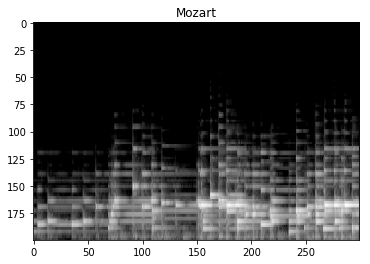

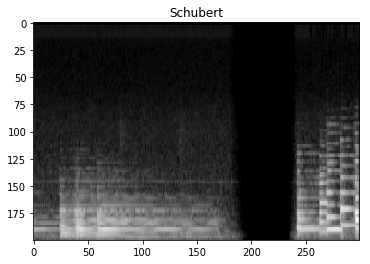

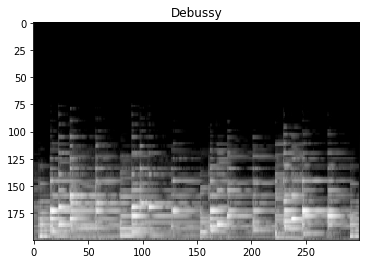

In [6]:
for element in full_ds.take(3):
    plt.imshow(tf.reshape(element[0][0],[200,300]),cmap = 'gray_r')
    plt.title(labels_dict_rev[element[1][0].numpy()])
    plt.show()

In [21]:
# model inititialization
model_name = 'composer_classifier_LSTM'
checkpoint_path = '{}.h5'.format(model_name)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weight_only = False,
                                                 verbose = 1)

# Model construction

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D,Reshape,Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D,BatchNormalization,LSTM
from tensorflow.keras.models import Model,Sequential

shape = (200,300,1)
batch_size = 16

#Classical classification convolutional model
input_layer = Input(shape=shape,batch_size = batch_size)

group1_Conv = Conv2D(filters = 8,kernel_size = (8,4),padding='same',activation='relu')
group1_Pool = MaxPooling2D(pool_size = (3,2))
group1_Norm = BatchNormalization()
drop_1 = Dropout(0.2)

group2_Conv = Conv2D(filters = 8,kernel_size = (8,4),padding='same',activation='relu')
group2_Pool = MaxPooling2D(pool_size = (2,2))
group2_Norm = BatchNormalization()
drop_2 = Dropout(0.2)

group3_Conv = Conv2D(filters = 16,kernel_size = (8,4),padding='same',activation='relu')
group3_Pool = MaxPooling2D(pool_size = (2,2))
group3_Norm = BatchNormalization()
drop_3 = Dropout(0.2)
out_reshape = Reshape((16,592))

out_LSTM = LSTM(units = 5,activation = 'sigmoid')

composer_classifier = Sequential([input_layer,
                                  group1_Conv,
                                  group1_Pool,
                                  group1_Norm,
                                  drop_1,
                                  group2_Conv,
                                  group2_Pool,
                                  group2_Norm,
                                  drop_2,
                                  group3_Conv,
                                  group3_Pool,
                                  group3_Norm,
                                  drop_3,
                                  out_reshape,
                                  out_LSTM])

# model parametrization
try:
    composer_classifier.load_weights(checkpoint_path)
    init = False
except OSError:
    init = True

#learning rate
initial_learning_rate = 0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=200,
    decay_rate=0.90,
    staircase=True)

# Optimizer
optimizer = tf.keras.optimizers.Adam(lr_schedule)

#Loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()

#Compile
composer_classifier.compile(optimizer = optimizer,loss = loss,metrics = [metric])


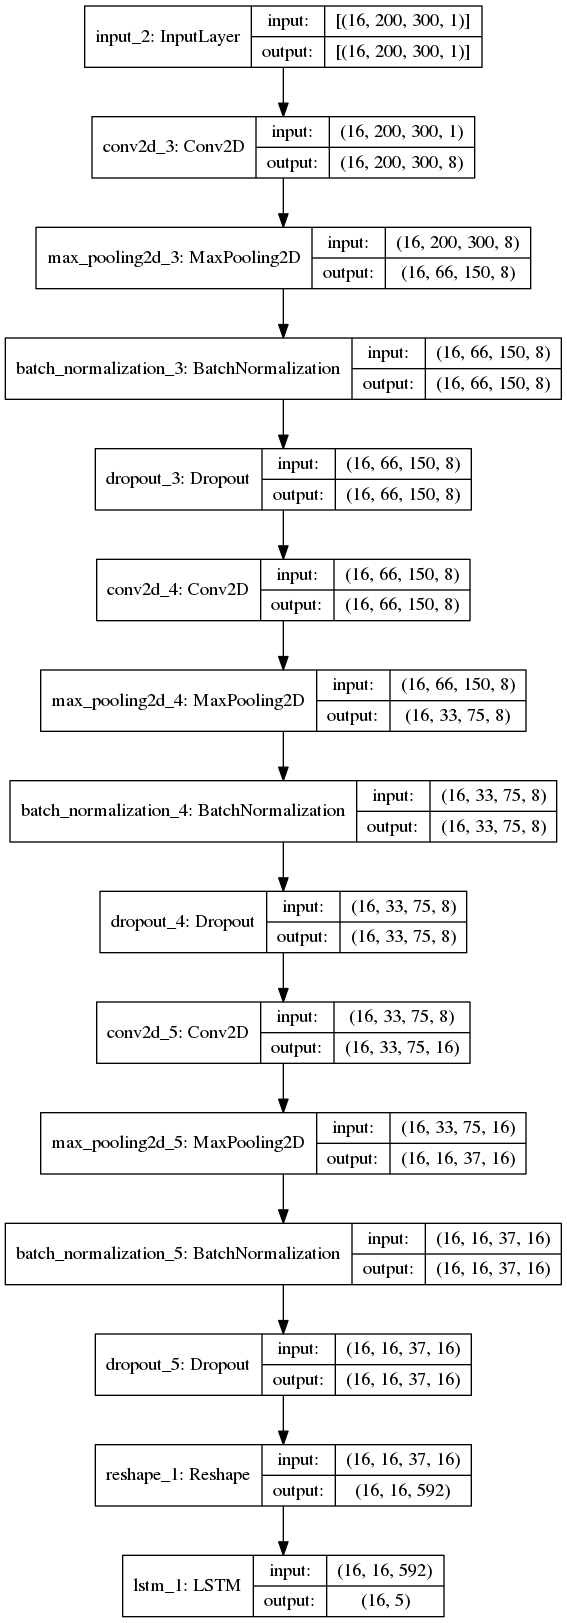

In [22]:
from tensorflow.keras.utils import plot_model
plot_model(composer_classifier,'model.png',show_shapes = True)

In [23]:
# train_test_split
n = int(len(labels)/16*2/3)
train_ds = full_ds.take(n)
test_ds = full_ds.skip(n)

In [24]:
composer_classifier.evaluate(train_ds),composer_classifier.evaluate(test_ds)

21/21 [==============================] - 1s 71ms/step - loss: 0.3372 - sparse_categorical_accuracy: 0.8899


([0.33863817155361176, 0.8828125], [0.33720392556417556, 0.88988096])

In [25]:
for batch in train_ds.take(1):
    print(batch[0].shape,
        batch[1].shape)

(16, 200, 300, 1) (16,)


In [26]:
history = composer_classifier.fit(train_ds,epochs=200,
                        validation_data=test_ds,
                        verbose = 1,
                        callbacks=[cp_callback])

Train for 48 steps, validate for 21 steps
Epoch 1/200
47/48 [============================>.] - ETA: 0s - loss: 0.3178 - sparse_categorical_accuracy: 0.8710
Epoch 00001: saving model to composer_classifier_LSTM.h5
48/48 [==============================] - 5s 107ms/step - loss: 0.3254 - sparse_categorical_accuracy: 0.8698 - val_loss: 0.2916 - val_sparse_categorical_accuracy: 0.8869
Epoch 2/200
47/48 [============================>.] - ETA: 0s - loss: 0.3336 - sparse_categorical_accuracy: 0.8870
Epoch 00002: saving model to composer_classifier_LSTM.h5
48/48 [==============================] - 4s 81ms/step - loss: 0.3362 - sparse_categorical_accuracy: 0.8854 - val_loss: 0.2565 - val_sparse_categorical_accuracy: 0.9107
Epoch 3/200
45/48 [===========================>..] - ETA: 0s - loss: 0.3264 - sparse_categorical_accuracy: 0.8861
Epoch 00003: saving model to composer_classifier_LSTM.h5
48/48 [==============================] - 4s 80ms/step - loss: 0.3247 - sparse_categorical_accuracy: 0.8867 -

KeyboardInterrupt: 

In [40]:
out_true = []
out_pred = []
for batch in test_ds:
    prediction = composer_classifier.predict(batch)
    predicted = [list(y).index(max(y)) for y in prediction]
    labels = list(batch[1].numpy())
    out_true = out_true + labels
    out_pred = out_pred + predicted

In [41]:
confusion = tf.math.confusion_matrix(labels=out_true, predictions=out_pred, num_classes=5)

In [42]:
confusion

<tf.Tensor: shape=(5, 5), dtype=int32, numpy=
array([[68,  0,  0,  0,  5],
       [ 0, 96,  9,  0,  3],
       [ 0,  0, 53,  0,  1],
       [ 4,  2,  0, 21,  3],
       [ 0,  0,  0,  0, 71]], dtype=int32)>

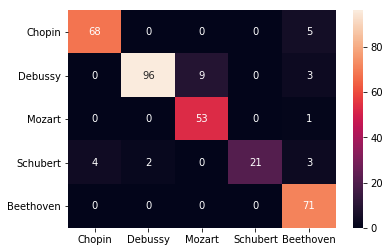

In [46]:
import seaborn as sns
labels_dict_rev = {1:'Debussy',2:'Mozart',3:'Schubert',4:'Beethoven',0:'Chopin'}
x_lab = [labels_dict_rev[i] for i in range(0,5)]
sns.heatmap(confusion,annot = True,xticklabels = x_lab,yticklabels = x_lab  )